<a href="https://colab.research.google.com/github/mathiashole/curso-RSG/blob/main/practico_secuencias_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MANEJO DE SECUENCIAS EN LÍNEA DE COMANDO**

_Martín Rivara (Unidad Académica de Genética - FMed, Departamento de Genómica - IIBCE)_ mrivara@fcien.edu.uy

_Paola Sosa Basso (Sección Genómica Funcional - FCien, Departamento de Genómica - IIBCE, Instituto de Investigación Una Salud - UdelaR)_ psosa@fcien.edu.uy


### **Exploración y análisis de archivos de secuencias**
Estos análisis se realizan en la **terminal** de la computadora o conectada a un servidor. Por razones de practicidad del curso lo realizaremos en la notebook.


En este práctico vamos a explorar datos de RNA-seq de **Streptomyces venezuelae**, usando herramientas básicas de línea de comando y bioinformática:  
- Archivos `fastq`, `fasta`, `gff`, `bam`  
- Comandos básicos: `wc`, `grep`, `head`, `tail`, `less`  
- Herramientas: `samtools`, `bedtools`, `seqtk`  

⚠️ Nota: Este práctico **no busca hacer un análisis completo de expresión diferencial**, sino aprender a explorar archivos de secuenciación y anotaciones en Linux.

# **1. INTRODUCCIÓN**

En este práctico trabajaremos con los datos publicados en el artículo  
[Genome-Wide Identification of the LexA-Mediated DNA Damage Response in *Streptomyces venezuelae*](https://doi.org/10.1128/jb.00108-22).


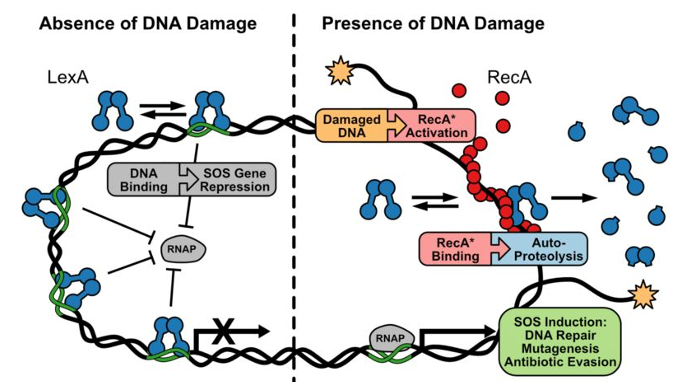
---

El **sistema SOS** es una respuesta bacteriana que se activa cuando el ADN sufre daños.  

- El regulador **LexA** es una proteína represora que **se une al ADN en regiones específicas** para bloquear la transcripción de genes asociados a la reparación.  
- Estas regiones del ADN contienen una secuencia característica llamada **"LexA box"** o **motivo de unión de LexA**.  
- En condiciones normales, LexA reconoce este motivo y mantiene los genes reprimidos.  
- Cuando ocurre daño genotóxico, la proteína **RecA** se activa y estimula la **autocleavage (autocorte) de LexA**. De esta forma, LexA se inactiva, deja de unirse al ADN, y los genes pueden expresarse.  

El resultado es la activación coordinada de múltiples genes que permiten a la célula **detectar, reparar y tolerar** el daño en el ADN.  

**Motivo de unión de LexA**

El motivo de unión de LexA suele ser una **secuencia palindrómica corta**, ubicada en los promotores de los genes regulados por el sistema SOS.  Aunque el motivo está **conservado de manera general en bacterias**, la secuencia exacta puede variar entre especies.  
En *Streptomyces venezuelae*, este estudio identificó **por primera vez el repertorio de motivos LexA y sus genes diana a nivel genómico**.  

El análisis de estos motivos no solo revela **qué genes están regulados directamente por LexA**, sino también nos ayuda a entender la **amplitud y particularidades** de la respuesta SOS en este género.  


Aunque el sistema SOS (LexA–RecA) está **ampliamente conservado en bacterias**, su **alcance y regulación** varían entre especies.  
  

Hasta hace poco, la respuesta SOS en *Streptomyces* **no había sido explorada sistemáticamente**, y el trabajo que analizaremos aporta información clave para comprender cómo actúa LexA y cómo son sus motivos de unión en este género.  


## **2. CARGAMOS ARCHIVOS E INSTALAMOS PROGRAMAS**

In [ ]:
# Montamos Google Drive para acceder a los archivos
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%bash
#creamos carpeta de trabajo y nos movemos a la carpeta
unzip /content/drive/MyDrive/practicoSecuencias.zip -d .


En esta celda definimos carpetas y archivos

In [ ]:
# Definimos la carpeta madre donde están los archivos
BASE = "/content/drive/MyDrive/practicoSecuencias"

# Subcarpetas
FASTQ_DIR = f"{BASE}/fastq"
REF_DIR   = f"{BASE}/ref"
BAM_DIR   = f"{BASE}/bam"

# Archivos de referencia (genoma y anotación)
GENOME_FA = f"{REF_DIR}/StreptomycesVenezuelae_NRRLB-65442.fasta"
GFF_FILE  = f"{REF_DIR}/StreptomycesVenezuelae_NRRLB-65442.gff3"

print("Archivos configurados correctamente ✅")


bash: line 1: BASE: command not found
bash: line 4: FASTQ_DIR: command not found
bash: line 5: REF_DIR: command not found
bash: line 6: BAM_DIR: command not found
bash: line 9: GENOME_FA: command not found
bash: line 10: GFF_FILE: command not found
bash: line 12: syntax error near unexpected token `"Archivos configurados correctamente ✅"'
bash: line 12: `print("Archivos configurados correctamente ✅")'


CalledProcessError: Command 'b'BASE = "/content/drive/MyDrive/Pr\xc3\xa1cticos/Semana4/practicoSecuencias"\n\n# Subcarpetas\nFASTQ_DIR = f"{BASE}/fastq"\nREF_DIR   = f"{BASE}/ref"\nBAM_DIR   = f"{BASE}/bam"\n\n# Archivos de referencia (genoma y anotaci\xc3\xb3n)\nGENOME_FA = f"{REF_DIR}/StreptomycesVenezuelae_NRRLB-65442.fasta"\nGFF_FILE  = f"{REF_DIR}/StreptomycesVenezuelae_NRRLB-65442.gff3"\n\nprint("Archivos configurados correctamente \xe2\x9c\x85")\n'' returned non-zero exit status 2.

En esta celda instalamos los softwares necesarios que no vienen instalados en linux.

In [ ]:
%%bash
# Instalación de softwares
apt-get update -qq
apt-get install -y samtools bedtools seqtk

Reading package lists...
Building dependency tree...
Reading state information...
samtools is already the newest version (1.13-4).
seqtk is already the newest version (1.3-2).
bedtools is already the newest version (2.30.0+dfsg-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
# Revisamos qué archivos tenemos en cada carpeta

print("FASTQ (lecturas de secuenciación):")
!ls -lh {FASTQ_DIR}

print("\nReferencia genómica:")
!ls -lh {REF_DIR}

print("\nArchivos BAM (alineamientos):")
!ls -lh {BAM_DIR}

FASTQ (lecturas de secuenciación):
total 951M
-rw------- 1 root root 157M Aug 27 22:36 500k_WT-UNTREATED-K1_R1.fastq
-rw------- 1 root root 9.4M Aug 28 00:29 500k_WT-UNTREATED-K1_R1_sub.fasta
-rw------- 1 root root  16M Aug 28 00:28 500k_WT-UNTREATED-K1_R1_sub.fastq
-rw------- 1 root root 158M Aug 27 22:37 500k_WT-UNTREATED-K1_R2.fastq
-rw------- 1 root root 151M Aug 27 22:38 500k_WT-UNTREATED-K2_R1.fastq
-rw------- 1 root root 153M Aug 27 22:39 500k_WT-UNTREATED-K2_R2.fastq
-rw------- 1 root root 154M Aug 27 22:40 500k_WT-UNTREATED-K3_R1.fastq
-rw------- 1 root root 156M Aug 27 22:41 500k_WT-UNTREATED-K3_R2.fastq

Referencia genómica:
total 13M
-rw------- 1 root root 8.0M Aug 27 16:35 StreptomycesVenezuelae_NRRLB-65442.fasta
-rw------- 1 root root 4.3M Aug 27 16:35 StreptomycesVenezuelae_NRRLB-65442.gff3

Archivos BAM (alineamientos):
total 34M
-rw------- 1 root root 34M Aug 28 00:35 500k_WT-UNTREATED-K1.sorted.bam


## **3. EXPLORAMOS LOS ARCHIVOS FASTQ**

Los archivos FASTQ contienen las lecturas crudas de secuenciación.  
Cada lectura ocupa **4 líneas**:
1. Identificador de la secuencia
2. Secuencia de nucleótidos
3. Separador "+"
4. Calidades de cada base

Vamos a ver ejemplos y contar cuántas lecturas hay.

In [ ]:
%%bash
# Ver las primeras líneas de un FASTQ
head -n 8 {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1.fastq

@A01174:55:HMYLGDSXY:4:2119:16740:18458 1:N:0:AAGCGACT+ACGAATCC
CATCGCTTACCTACTACCACCTTGGGTCAGCGGCTCCACCACTTTCCTTTCCCCGAAGGGTCCGGAACGGCTTCACGGCCTTAGCATTAATGGGCTCGATATTGGGCGTTTCAAAGCG
+
FF:FFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFF::FFF:FFFFFFFFFFFF,,FFFFFFFFFFFFFFFFF
@A01174:55:HMYLGDSXY:4:1668:9372:16438 1:N:0:AAGCGACT+ACGAATCC
GCGGGGCGACGGCCGGGGTGCGCAGGACGATCTCCTCGATCTGGGTGGGGAAGAGGTTCACCCCGCGCAGGATGATCATGTCGTCGCTGCGGCCGGTGACCTTCTCCATCCGCCGGAACACCCGCGCGGTGCCCGGCAGCAGCCGGGTC
+
FFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


In [ ]:
%%bash

# En un archivo FASTQ, cada lectura ocupa 4 líneas.
# Entonces: número de lecturas = número de líneas / 4

# Contar cuántas líneas y calcular cuántas lecturas hay
wc -l {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1.fastq

# Como cada lectura son 4 líneas:
expr $(wc -l < {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1.fastq) / 4


2000000 /content/drive/MyDrive/Prácticos/Semana4/practicoSecuencias/fastq/500k_WT-UNTREATED-K1_R1.fastq
500000


## **4. EXPLORAREMOS LOS DIFERENTES ARCHIVOS DE SECUENCIAS Y FORMATOS DE ANOTACIÓN DE GENES**



## ```FASTA``` - genoma de referencia

Un archivo FASTA es un formato de texto utilizado para almacenar secuencias biológicas, como secuencias de ADN, ARN o proteínas.

El archivo FASTA contiene la secuencia del genoma de referencia de **S. venezuelae**.

Estructura básica:


*   Línea 1: Comienza con el símbolo > seguido por un identificador o descripción de la secuencia
*   Líneas siguientes: contienen la secuencia, dividida en líneas o en una sola línea, existen ambos casos


```
>seq1 info de la secuencia
ATGCGTACGTAGCTAGCTAGCTAGCTAGCTA

In [ ]:
%%bash
# Mostrar solo las primeras líneas de la secuencia
head -n 10 {REF_DIR}/StreptomycesVenezuelae_NRRLB-65442.fasta


>NZ_CP018074.1 Streptomyces venezuelae strain NRRL B-65442 chromosome
TGAGAGCCGATGCTGGACACGTACTCGTACTGACCCCACTGGGAGCCGAGGTCCTGGACGACCTCACCAA
CCCAGATGTCGTCCATGCCGGCATGGTCATCAGCAGCCCACGCGCCGATGATCCGGTCCCACCGACGAAC
GTTCAGGTGCCGGTACTCCACAACCCGTTGGAGAGGACGTGCGACCTGGGACTGATTGAGGGGGTGGAAC
TCCACGCGTGTGCCGCGTCCCTGCCGGTTGAGACGGTTCAGAAGGTACCGGGCGACGTTCTGACGCCGTA
CGGCACGATACGCAGACTCGATACGTTCCAAGTTCCGATGTGAAGGAGCGCGCTTGCCCTCCCGCCAAGC
TCTGATGGTCCGGTCCGTGACGGTCAGGCCAGCCGCACGCGCGGCCTGACGAGCGTGCTCACTCCGGGTG
AGATAGTTCAGCCTCGCCATCAGACCACGCCGCTGCTCAACCGGCGTCACCACAAAGCCCGCAAGCTCAT
CCAGCTGACGCGCCACCAACTCATGACCCTTCACACCACGAGCCCCGAACTTCCCGAAATCAATCACCCG
CTCCGGCACAACCCCACCCCCCATCCACCACTAAACCGCCCCCACAGCGAGAGCATGCCGTAAATACCTA


In [ ]:
%%bash
# Ver los encabezados del archivo fasta (líneas que empiezan con ">")
grep ">" {REF_DIR}/StreptomycesVenezuelae_NRRLB-65442.fasta

>NZ_CP018074.1 Streptomyces venezuelae strain NRRL B-65442 chromosome


## ```GFF``` - anotación

Un archivo GFF (General Feature Format) es un formato  usado para describir anotaciones de características genómicas sobre una secuencia (como genes, exones, intrones, regiones regulatorias, etc.).

**Estructura:**

Cada línea representa una característica genética y tiene 9 campos separados por tabulaciones:

1.   Secuencia (ej. cromosoma o contig)
2.   Fuente (programa o base de datos que generó la anotación)
3.   Tipo/feature (ej. gene, exon, CDS)
4.   Inicio (posición de inicio en la secuencia)
5.   Fin (posición final)
6.   Score (valor numérico opcional, puede ser ".")
7.   Hebra (+, - o .)
8.   Frame (fase de lectura: 0, 1, 2, o ".")
9.   Atributos (información extra en formato clave=valor)

In [ ]:
%%bash
# Ver las primeras líneas del archivo
head -n 10 {REF_DIR}/StreptomycesVenezuelae_NRRLB-65442.gff3

##gff-version 3
#!gff-spec-version 1.21
#!processor NCBI annotwriter
##sequence-region NZ_CP018074.1 1 8222198
##species https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=54571
NZ_CP018074.1	RefSeq	region	1	8222198	.	+	.	ID=NZ_CP018074.1:1..8222198;Dbxref=taxon:54571;Name=ANONYMOUS;collection-date=2016-10-31;country=United Kingdom: Norwich;culture-collection=NRRL:B-65442;gbkey=Src;genome=chromosome;mol_type=genomic DNA;strain=NRRL B-65442
NZ_CP018074.1	RefSeq	gene	1	569	.	-	.	ID=gene-vnz_RS00005;Name=vnz_RS00005;gbkey=Gene;gene_biotype=protein_coding;locus_tag=vnz_RS00005;old_locus_tag=vnz_00005;partial=true;start_range=.,1
NZ_CP018074.1	Protein Homology	CDS	1	569	.	-	0	ID=cds-WP_071892363.1;Parent=gene-vnz_RS00005;Dbxref=GenBank:WP_071892363.1;Name=WP_071892363.1;gbkey=CDS;inference=COORDINATES: similar to AA sequence:RefSeq:WP_014043969.1;locus_tag=vnz_RS00005;partial=true;product=transcriptional regulator;protein_id=WP_071892363.1;start_range=.,1;transl_table=11
NZ_CP01807

In [ ]:
%%bash
# Contamos y listamos los tipos de anotaciones
grep -v '^#' {REF_DIR}/StreptomycesVenezuelae_NRRLB-65442.gff3 | awk '{c[$3]++} END{for(k in c) print k, c[k]}' | sort -k2,2nr | head

gene 7362
Homology 6985
CDS 357
exon 95
pseudogene 74
tRNA 69
riboswitch 29
rRNA 21
pseudogenic_tRNA 1
region 1


# **5. TRABAJAMOS CON DATOS DE SECUENCIACIÓN** del paper



##  `seqtk` - Manipulación de lecturas

In [ ]:
%%bash
# Utilizaremos el software seqtk
seqtk

/bin/bash: line 1: seqtk: command not found


In [ ]:
%%bash
# Ver primeras lecturas
seqtk seq {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1.fastq | head -n 8


@A01174:55:HMYLGDSXY:4:2119:16740:18458 1:N:0:AAGCGACT+ACGAATCC
CATCGCTTACCTACTACCACCTTGGGTCAGCGGCTCCACCACTTTCCTTTCCCCGAAGGGTCCGGAACGGCTTCACGGCCTTAGCATTAATGGGCTCGATATTGGGCGTTTCAAAGCG
+
FF:FFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFF::FFF:FFFFFFFFFFFF,,FFFFFFFFFFFFFFFFF
@A01174:55:HMYLGDSXY:4:1668:9372:16438 1:N:0:AAGCGACT+ACGAATCC
GCGGGGCGACGGCCGGGGTGCGCAGGACGATCTCCTCGATCTGGGTGGGGAAGAGGTTCACCCCGCGCAGGATGATCATGTCGTCGCTGCGGCCGGTGACCTTCTCCATCCGCCGGAACACCCGCGCGGTGCCCGGCAGCAGCCGGGTC
+
FFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


In [ ]:
%%bash
#Chequeo general del fastq
seqtk fqchk {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1.fastq | head -8

min_len: 35; max_len: 151; avg_len: 130.28; 4 distinct quality values
POS	#bases	%A	%C	%G	%T	%N	avgQ	errQ	%low	%high
ALL	65137875	15.9	32.6	30.9	20.3	0.3	36.5	25.9	1.1	98.9
1	500000	5.7	44.3	41.5	7.2	1.3	36.2	21.3	2.1	97.9
2	500000	9.6	30.5	38.3	20.3	1.3	36.2	21.4	2.0	98.0
3	500000	17.9	34.6	31.7	14.5	1.3	36.2	21.4	2.0	98.0
4	500000	19.7	26.9	38.9	13.2	1.3	36.2	21.4	2.0	98.0
5	500000	20.5	20.4	39.0	18.8	1.3	36.2	21.4	2.0	98.0


In [ ]:
%%bash
# Usamos seqtk para tomar una lectura aleatoria del archivo FASTQ
seqtk sample {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1.fastq 1


@A01174:55:HMYLGDSXY:4:1207:32660:24987 1:N:0:AAGCGACT+ACGAATCC
CGAGGCGAGGACGTCCGTTTTGGCGCGCTCCGCGGCCGCGTACGCGCGGGCCGATGCGGCGGCGTGCTCATCGAGGGGCTGGCGGGCGGGCGCGGGGGCCGACTGCTGGCTCATCCGAGGCTCCTG
+
FFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:F


In [ ]:
%%bash
# Submuestrear el 10%
seqtk sample -s100 {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1.fastq 0.1 > {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1_sub.fastq
ls -lh {FASTQ_DIR}
wc -l {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1_sub.fastq

total 942M
-rw------- 1 root root 157M Aug 27 22:36 500k_WT-UNTREATED-K1_R1.fastq
-rw------- 1 root root  16M Aug 28 00:28 500k_WT-UNTREATED-K1_R1_sub.fastq
-rw------- 1 root root 158M Aug 27 22:37 500k_WT-UNTREATED-K1_R2.fastq
-rw------- 1 root root 151M Aug 27 22:38 500k_WT-UNTREATED-K2_R1.fastq
-rw------- 1 root root 153M Aug 27 22:39 500k_WT-UNTREATED-K2_R2.fastq
-rw------- 1 root root 154M Aug 27 22:40 500k_WT-UNTREATED-K3_R1.fastq
-rw------- 1 root root 156M Aug 27 22:41 500k_WT-UNTREATED-K3_R2.fastq
201344 /content/drive/MyDrive/Prácticos/Semana4/practicoSecuencias/fastq/500k_WT-UNTREATED-K1_R1_sub.fastq


In [ ]:
%%bash
# Convertir a FASTA
seqtk seq -A {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1_sub.fastq > {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1_sub.fasta
head {FASTQ_DIR}/500k_WT-UNTREATED-K1_R1_sub.fasta

>A01174:55:HMYLGDSXY:4:2466:23122:26475 1:N:0:AAGCGACT+ACGAATCC
GTGCAGGAGCAGGTCGTGGGCCTGCTGCCACTTGCCGGCCGCGAAGGCCTCCTCGCCGATCTCCGCGCGGATCGCGGCCAGTTCCTCGGCGGCGACCTCGCGGGCCAGTTCCGGGGTGGCGGTCTTGCCGTTC
>A01174:55:HMYLGDSXY:4:1320:23918:3740 1:N:0:AAGCGACT+ACGAATCC
CCGGGGCCACCGGTCCGGGCGCGCGGGAGGAATCGGGTGACGGCGGAGGAGGCGGAGGTCATGGCGACCACCTTGCGCCACGGAGACACCCCCGGGGTAGAGACATCGGTCACGTCGCCCGGGGCCACCCTGCCGGACCAGCCGATCCCG
>A01174:55:HMYLGDSXY:4:1351:32777:25755 1:N:0:AAGCGACT+ACGAATCC
GGAATATTTAGGCTTAGCGGGTGGTCCCGCCAGATTCACACGGGATTTCTCGGGCCCCGTGCTACTTGGGTGTCTCTCAAACGAGCCGTCAATGTTTCAGCTACGGGGGTCTTACCCTCTACGCCGGACCTTTCGCATGTCCTTCGCCTAC
>A01174:55:HMYLGDSXY:4:2639:17056:33536 1:N:0:AAGCGACT+ACGAATCC
CTGGTCGAACTGCACCGACCGGAAGGCGGCCCGACGCTCGCGTTCCGCCCGGGCCCCCCGGTCCGCGCGGTCGCCGTCACCGGCGGCGGCTCCCTGCTCATCGGCAC
>A01174:55:HMYLGDSXY:4:1561:24542:10332 1:N:0:AAGCGACT+ACGAATCC
CCCCGTGCTACTTGGGTGTCTCTCAAACGAGCCGTCAATGTTTCAGCTACGGGGGTCTTACCCTCTACGCCGGACCTTTCGCATGTCCTTCGCCTACATCAACGGTTTCTGACTCGTCTCACAGCCGGCAGACTGT

## `samtools` - Estadísticas de BAM

Trabajaremos sobre archivo de ```. bam``` de mapeo de los reads. Para generar este archivo, ejecutamos los siguiente comandos

Mapeamos los reads al genoma
```
bowtie
```

Transformamos el ```. sam``` a  ```.bam```
```
samtools view
```




In [ ]:
%%bash
samtools quickcheck {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam

In [ ]:
%%bash
#Vemos el header del bam, donde esta la informacion del mapeo
samtools view -H {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam | head -20

@HD	VN:1.5	SO:coordinate
@SQ	SN:NZ_CP018074.1	LN:8222198
@PG	ID:bowtie2	PN:bowtie2	VN:2.5.4	CL:"/mnt/Disk04/mrivara/miniconda3/envs/cursoRSG/bin/bowtie2-align-s --wrapper basic-0 -x genoma/Svenezuelae_index -S mapeos/500k_WT-UNTREATED-K1.sam --threads 8 -1 ctrl_reads/500k_WT-UNTREATED-K1_R1.fastq -2 ctrl_reads/500k_WT-UNTREATED-K1_R2.fastq"
@PG	ID:samtools	PN:samtools	PP:bowtie2	VN:1.22.1	CL:samtools view -bS mapeos/500k_WT-UNTREATED-K1.sam
@PG	ID:samtools.1	PN:samtools	PP:samtools	VN:1.22.1	CL:samtools sort -o mapeos/500k_WT-UNTREATED-K1.sorted.bam
@PG	ID:samtools.2	PN:samtools	PP:samtools.1	VN:1.13	CL:samtools view -H /content/drive/MyDrive/Prácticos/Semana4/practicoSecuencias/bam/500k_WT-UNTREATED-K1.sorted.bam


In [ ]:
%%bash
# Ver estadísticas
samtools flagstat {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam

1000000 + 0 in total (QC-passed reads + QC-failed reads)
1000000 + 0 primary
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
971184 + 0 mapped (97.12% : N/A)
971184 + 0 primary mapped (97.12% : N/A)
1000000 + 0 paired in sequencing
500000 + 0 read1
500000 + 0 read2
963672 + 0 properly paired (96.37% : N/A)
967920 + 0 with itself and mate mapped
3264 + 0 singletons (0.33% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [ ]:
%%bash
#Lecturas con calidad de mapeo > 30
samtools view -c -q 30 -F 0x904 {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam

#Lecturas no mapeadas
samtools view -c -f 0x4 {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam

971184
457531
28816


In [ ]:
%%bash
# Profundidad por posición
samtools depth {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam | head -50

NZ_CP018074.1	2	1
NZ_CP018074.1	3	1
NZ_CP018074.1	4	1
NZ_CP018074.1	5	1
NZ_CP018074.1	6	2
NZ_CP018074.1	7	2
NZ_CP018074.1	8	2
NZ_CP018074.1	9	2
NZ_CP018074.1	10	2
NZ_CP018074.1	11	2
NZ_CP018074.1	12	2
NZ_CP018074.1	13	2
NZ_CP018074.1	14	2
NZ_CP018074.1	15	3
NZ_CP018074.1	16	3
NZ_CP018074.1	17	3
NZ_CP018074.1	18	3
NZ_CP018074.1	19	3
NZ_CP018074.1	20	3
NZ_CP018074.1	21	3
NZ_CP018074.1	22	3
NZ_CP018074.1	23	3
NZ_CP018074.1	24	3
NZ_CP018074.1	25	3
NZ_CP018074.1	26	3
NZ_CP018074.1	27	3
NZ_CP018074.1	28	3
NZ_CP018074.1	29	3
NZ_CP018074.1	30	3
NZ_CP018074.1	31	3
NZ_CP018074.1	32	3
NZ_CP018074.1	33	3
NZ_CP018074.1	34	3
NZ_CP018074.1	35	4
NZ_CP018074.1	36	4
NZ_CP018074.1	37	4
NZ_CP018074.1	38	4
NZ_CP018074.1	39	4
NZ_CP018074.1	40	4
NZ_CP018074.1	41	4
NZ_CP018074.1	42	4
NZ_CP018074.1	43	4
NZ_CP018074.1	44	4
NZ_CP018074.1	45	4
NZ_CP018074.1	46	4
NZ_CP018074.1	47	5
NZ_CP018074.1	48	5
NZ_CP018074.1	49	5
NZ_CP018074.1	50	5
NZ_CP018074.1	51	5


In [ ]:
%%bash
# Indexar BAM
samtools index {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam

## Generamos `BED` a partir del `GFF`

In [ ]:
%%bash
grep -v '^#' {REF_DIR}/StreptomycesVenezuelae_NRRLB-65442.gff3 | awk '$3=="CDS"{split($9,a,";"); id=a[1]; gsub("ID=","",id); start=$4-1; end=$5; print $1"\t"start"\t"end"\t"id"\t0\t"$7}' | sort -k1,1 -k2,2n > {REF_DIR}/genes_cds.bed


In [ ]:
%%bash
head -20 {REF_DIR}/genes_cds.bed

NZ_CP018074.1	1092	1605	cds-WP_145953680.1	0	+
NZ_CP018074.1	9808	10252	cds-WP_186102817.1	0	+
NZ_CP018074.1	31117	32122	cds-WP_015031244.1	0	-
NZ_CP018074.1	32125	32632	cds-WP_015031245.1	0	-
NZ_CP018074.1	86946	87183	cds-WP_145953681.1	0	-
NZ_CP018074.1	91648	92386	cds-WP_015031301.1	0	-
NZ_CP018074.1	157515	157983	cds-WP_015031359.1	0	+
NZ_CP018074.1	202597	203047	cds-WP_186102818.1	0	-
NZ_CP018074.1	204757	205825	cds-WP_015031401.1	0	+
NZ_CP018074.1	205932	206919	cds-WP_145953683.1	0	+
NZ_CP018074.1	223218	223530	cds-WP_041661936.1	0	+
NZ_CP018074.1	286840	289078	cds-WP_308340063.1	0	-
NZ_CP018074.1	339572	339836	cds-WP_015031526.1	0	+
NZ_CP018074.1	412625	413222	cds-WP_015031591.1	0	-
NZ_CP018074.1	469010	469301	cds-WP_015031644.1	0	-
NZ_CP018074.1	472256	472655	cds-WP_015031647.1	0	+
NZ_CP018074.1	474857	477395	cds-WP_015031650.1	0	+
NZ_CP018074.1	552761	553970	cds-WP_015031708.1	0	+
NZ_CP018074.1	630390	630939	cds-WP_145953687.1	0	-
NZ_CP018074.1	648794	649190	cds-WP_145953688.1

In [ ]:
%%bash
#Estudiar el coverage por posicion
bedtools genomecov -ibam {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam -g <(samtools view -H {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam | awk '$1=="@SQ"{for(i=1;i<=NF;i++){if($i ~ /^SN:/){sn=substr($i,4)} if($i ~ /^LN:/){ln=substr($i,4)}}; print sn"\t"ln}') | head -n 20



*****
*****WARNING: Genome (-g) files are ignored when BAM input is provided. 
*****
NZ_CP018074.1	0	3689588	8222198	0.448735
NZ_CP018074.1	1	556862	8222198	0.0677267
NZ_CP018074.1	2	922367	8222198	0.11218
NZ_CP018074.1	3	374358	8222198	0.0455302
NZ_CP018074.1	4	422999	8222198	0.051446
NZ_CP018074.1	5	249684	8222198	0.0303671
NZ_CP018074.1	6	240925	8222198	0.0293018
NZ_CP018074.1	7	168081	8222198	0.0204423
NZ_CP018074.1	8	155593	8222198	0.0189235
NZ_CP018074.1	9	119716	8222198	0.0145601
NZ_CP018074.1	10	108744	8222198	0.0132257
NZ_CP018074.1	11	86508	8222198	0.0105213
NZ_CP018074.1	12	82818	8222198	0.0100725
NZ_CP018074.1	13	69963	8222198	0.00850904
NZ_CP018074.1	14	63356	8222198	0.00770548
NZ_CP018074.1	15	54689	8222198	0.00665138
NZ_CP018074.1	16	51549	8222198	0.00626949
NZ_CP018074.1	17	45348	8222198	0.00551531
NZ_CP018074.1	18	42770	8222198	0.00520177
NZ_CP018074.1	19	39078	8222198	0.00475274


## `bedtools` - Intersección y cobertura

In [ ]:
%%bash
# Intersección con BED
bedtools intersect -a {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam -b {REF_DIR}/genes_cds.bed -bed > interseccion_reads.bed
head interseccion_reads.bed

NZ_CP018074.1	1217	1329	A01174:55:HMYLGDSXY:4:1510:15365:13604/2	42	+	1217	1329	0,0,0	1	112,	0,
NZ_CP018074.1	1217	1329	A01174:55:HMYLGDSXY:4:1510:15365:13604/1	42	-	1217	1329	0,0,0	1	112,	0,
NZ_CP018074.1	10111	10207	A01174:55:HMYLGDSXY:4:1640:12726:8782/2	42	+	10111	10207	0,0,0	1	96,	0,
NZ_CP018074.1	10111	10207	A01174:55:HMYLGDSXY:4:1640:12726:8782/1	42	-	10111	10207	0,0,0	1	96,	0,
NZ_CP018074.1	31214	31339	A01174:55:HMYLGDSXY:4:1314:15845:31501/1	42	+	31214	31339	0,0,0	1	125,	0,
NZ_CP018074.1	31214	31339	A01174:55:HMYLGDSXY:4:1314:15845:31501/2	42	-	31214	31339	0,0,0	1	125,	0,
NZ_CP018074.1	31263	31414	A01174:55:HMYLGDSXY:4:1266:20961:4319/1	42	+	31263	31414	0,0,0	1	151,	0,
NZ_CP018074.1	31334	31484	A01174:55:HMYLGDSXY:4:1417:20952:8531/1	42	+	31334	31484	0,0,0	1	150,	0,
NZ_CP018074.1	31369	31520	A01174:55:HMYLGDSXY:4:1417:20952:8531/2	42	-	31369	31520	0,0,0	1	151,	0,
NZ_CP018074.1	31969	32120	A01174:55:HMYLGDSXY:4:2524:4571:2487/1	42	+	31969	32120	0,0,0	1	151,	0,


In [ ]:
%%bash
# Cobertura por gen
bedtools coverage -a genes_cds.bed -b {BAM_DIR}/500k_WT-UNTREATED-K1.sorted.bam > cobertura.txt
head cobertura.txt

NZ_CP018074.1	1092	1605	cds-WP_145953680.1	0	+	2	112	513	0.2183236
NZ_CP018074.1	9808	10252	cds-WP_186102817.1	0	+	2	96	444	0.2162162
NZ_CP018074.1	31117	32122	cds-WP_015031244.1	0	-	9	459	1005	0.4567164
NZ_CP018074.1	32125	32632	cds-WP_015031245.1	0	-	9	388	507	0.7652860
NZ_CP018074.1	86946	87183	cds-WP_145953681.1	0	-	0	0	237	0.0000000
NZ_CP018074.1	91648	92386	cds-WP_015031301.1	0	-	8	565	738	0.7655827
NZ_CP018074.1	157515	157983	cds-WP_015031359.1	0	+	6	462	468	0.9871795
NZ_CP018074.1	202597	203047	cds-WP_186102818.1	0	-	4	136	450	0.3022222
NZ_CP018074.1	204757	205825	cds-WP_015031401.1	0	+	2	262	1068	0.2453184
NZ_CP018074.1	205932	206919	cds-WP_145953683.1	0	+	6	350	987	0.3546099
